In [27]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas
import psycopg2
import config
from config import db_pw

In [28]:
#establishing the connection
conn = psycopg2.connect(
   database="Predictive_Senescence_DB", user='postgres', password= db_pw, host='predictive-senescence-db.cbunnafql9ym.us-east-2.rds.amazonaws.com', port= '5432'
)

#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Retrieving data
cursor.execute('''SELECT * from birds_data_raw''')

#Fetching 1st row from the table
df = pd.DataFrame(cursor.fetchall(), columns=["Collection_Num", "BirdID", "Sex", "AgeY", "AgeClass", "BirthFPID", "U_PlateID", "RTL", "Technician", "Terr", "FPID", 'mum', 'dad', "MAC", 'PAC','BrF', 'BrM']);
print(df)

#Commit your changes in the database
conn.commit()

#Closing the connection
conn.close()

      Collection_Num  BirdID  Sex       AgeY AgeClass  BirthFPID U_PlateID  \
0                  1    5511    0   0.246575        J        103       9_3   
1                  2    5559    1   3.597260        A        103       9_1   
2                  3    5559    1   4.715068        A        103      9_28   
3                  4    5559    1   0.657534       SA        103       9_2   
4                  5    5527    1   0.328767      OFL        103       9_3   
...              ...     ...  ...        ...      ...        ...       ...   
2657            2658     221    1   6.958904        A          8       2_1   
2658            2659     216    1   8.947945        A          8       8_8   
2659            2660     176    1   6.772603        A          8      7_32   
2660            2661     221    1   9.090411        A          8      1_12   
2661            2662     176    1  13.873973        A          8       4_3   

       RTL  Technician   Terr  FPID   mum   dad       MAC      

<AxesSubplot:title={'center':'AgeY'}, xlabel='[AgeClass]'>

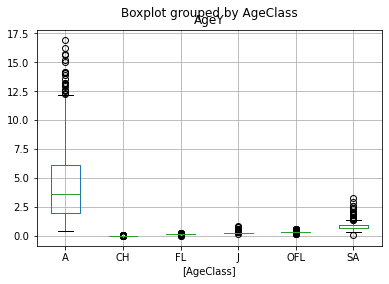

In [29]:
from matplotlib import pyplot as plt
# Plot boxplots of RTL by AgeClass
df.boxplot(['AgeY'], by=['AgeClass'])
#plt.savefig('AllClass.png')

In [30]:
df['AgeClass'] = df['AgeClass'].apply(lambda x: x if x in ('A') else 'Y')

In [31]:
y = df['AgeClass']
y = LabelEncoder().fit_transform(y)
#y = y.dropna()

#y.head()

<AxesSubplot:title={'center':'AgeY'}, xlabel='[AgeClass]'>

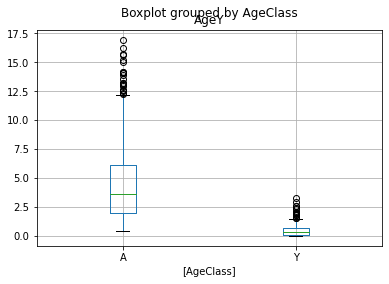

In [32]:
from matplotlib import pyplot as plt
# Plot boxplots of RTL by AgeClass
df.boxplot(['AgeY'], by=['AgeClass'])
#plt.savefig('TwoClass.png')

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

In [34]:

X= df[['RTL']]

In [35]:
print("Shape: ", X.shape, y.shape)

Shape:  (2662, 1) (2662,)


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [37]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver= 'newton-cg',class_weight = 'balanced',
                                max_iter=200,
                                random_state=1)
classifier

LogisticRegression(class_weight='balanced', max_iter=200, random_state=1,
                   solver='newton-cg')

In [38]:
classifier.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=200, random_state=1,
                   solver='newton-cg')

In [39]:
y_pred=classifier.predict(X_test_scaled)
results= pd.DataFrame({"prediction": y_pred, "Actual": y_test}).reset_index(drop=True)

In [40]:
print(f"Training Data Score: {classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_scaled, y_test)}")

Training Data Score: 0.5385771543086172
Testing Data Score: 0.5780780780780781


In [41]:
predictions = classifier.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})


,Prediction,Actual
0,1,0
1,1,1
2,1,1
3,1,1
4,0,1
...,...,...
661,0,0
662,1,0
663,1,1
664,0,0


### Cross validation and Confusion matrix

In [42]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas
import psycopg2
import config
from config import db_pw
import seaborn as sns
import pandas as pd
import numpy as np 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [43]:
# 5 folds selected
# https://python.plainenglish.io/using-k-fold-cross-validation-to-evaluate-the-performance-of-logistic-regression-4439215f24c4
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
model = LogisticRegression(solver='liblinear')
results = cross_val_score(model, X, y, cv=kfold)
# Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 54.621% (1.906%)


In [44]:
# Construct a confusion matrix
test_size = 0.33
seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
random_state=seed)
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
predicted = model.predict(X_test)
matrix = confusion_matrix(y_test, predicted)
print(matrix)

[[330 128]
 [267 154]]


In [45]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = y_test
y_pred = model.predict(X_test)
cm=confusion_matrix(y_true, y_pred)

In [46]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5506257110352674


In [47]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.72      0.63       458
           1       0.55      0.37      0.44       421

    accuracy                           0.55       879
   macro avg       0.55      0.54      0.53       879
weighted avg       0.55      0.55      0.54       879



In [48]:
# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,330,128
Actual 1,267,154


In [49]:
# Calculate the precision of the model based on the confusion matrix
precision = tp / (tp + fp)
precision

0.5460992907801419

In [50]:
# Calculate the sensitivity of the model based on the confusion matrix
sensitivity = tp / (tp + fn)
sensitivity

0.3657957244655582

128 birds were predicted to be adult when they were actually young. 267 birds were predicted to be young when they were actually adults. Telomere length alone is slightly better than flipping a coin at predicting Age class. precision is .55 for true classification of young sensitivity is .37 for true classification of adult f1 is .63 which is an indication that the model is miss classifiying a llot of individuals

In [51]:
#transform confusion matrix into array
#the matrix is stored in a vaiable called confmtrx
confmtrx = np.array(matrix)
#Create DataFrame from confmtrx array 
#rows for test: Churn, No_Churn designation as index 
#columns for preds: Pred_Churn, Pred_NoChurn as column
pd.DataFrame(confmtrx, index=['Young','Adult'],
columns=['Predicted_Young', 'Predicted_Adult', ])

,Predicted_Young,Predicted_Adult
Young,330,128
Adult,267,154


In [52]:
# best model selection
kfold = model_selection.KFold(n_splits=5, random_state=5, shuffle=True)
model = LogisticRegression()
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print("Accuracy: Final mean:%.3f%%, Final standard deviation:(%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
print('Accuracies from each of the 5 folds using kfold:',results)
print("Variance of kfold accuracies:",results.var())

Accuracy: Final mean:54.807%, Final standard deviation:(1.903%)
Accuracies from each of the 5 folds using kfold: [0.57786116 0.54409006 0.52443609 0.53383459 0.56015038]
Variance of kfold accuracies: 0.00036209948634715916


Accuracy is roughly the same for all models, cross validation, multiple test train splits, and multiple solvers. 